# 사전 준비 (Import, Mount)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

### 데이터 프레임 만들기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sdir=r'../content/drive/MyDrive/딥러닝_프로젝트_과채어때컴퍼니조/data_augmentation'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths        labels
0  ../content/drive/MyDrive/딥러닝_프로젝트_과...  stale_orange
1  ../content/drive/MyDrive/딥러닝_프로젝트_과...  stale_orange
2  ../content/drive/MyDrive/딥러닝_프로젝트_과...  stale_orange
3  ../content/drive/MyDrive/딥러닝_프로젝트_과...  stale_orange
4  ../content/drive/MyDrive/딥러닝_프로젝트_과...  stale_orange
stale_banana          5376
stale_apple           5312
fresh_apple           4752
fresh_cherryTomato    4688
fresh_banana          4544
fresh_orange          4016
stale_orange          3824
fresh_capsicum        3296
stale_capsicum        2592
stale_strawberry      1960
stale_cherryTomato    1168
fresh_pepper           384
fresh_strawberry       379
fresh_peach            144
fresh_grape             80
stale_peach             80
stale_pepper            16
Name: labels, dtype: int64


### 데이터 분할

In [ ]:
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  4492   test_df length:  250   valid_df length:  250


### 학습, 테스트, 검증용 제너레이터 생성

In [ ]:
height=128
width=128
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # 픽셀을 -1과 1사이로 지정
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  50   test steps:  5


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 15 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 4477 validated image filenames belonging to 20 classes.
Found 249 validated image filenames belonging to 20 classes.
Found 249 validated image filenames belonging to 20 classes.
['fresh_apple', 'fresh_banana', 'fresh_broccoli', 'fresh_capsicum', 'fresh_cherryTomato', 'fresh_grape', 'fresh_mandarin', 'fresh_orange', 'fresh_pepper', 'fresh_strawberry', 'stale_apple', 'stale_banana', 'stale_broccoli', 'stale_capsicum', 'stale_cherryTomato', 'stale_grape', 'stale_mandarin', 'stale_orange', 'stale_pepper', 'stale_strawberry']


###   클래스당 학습 샘플에 기반해서 가중치 딕셔너리를 정의함

In [ ]:
class_weight={}
train_dict=train_gen.class_indices
classes=list(train_dict.keys())
class_count=len(classes)
labels=train_gen.labels
count_array=np.zeros((class_count))
for label in labels:
    for value in train_dict.values():
        if label==value:
            count_array[value] +=1    
#print (count_array)
max_samples=np.max(count_array)
msg='{0:^30s}{1:^10s}{2:^9s}'.format('Class', 'Samples', 'Weight')
print(msg)
for i in range (class_count):
    class_weight[i]= max_samples/count_array[i]
    msg=f'{classes[i]:^30s}{str(count_array[i]):^10s}{class_weight[i]:^9.5f}'
    print (msg)


            Class              Samples   Weight  
         fresh_apple            266.0    1.63534 
         fresh_banana           254.0    1.71260 
        fresh_broccoli           79.0    5.50633 
        fresh_capsicum          180.0    2.41667 
      fresh_cherryTomato        256.0    1.69922 
         fresh_grape            423.0    1.02837 
        fresh_mandarin          318.0    1.36792 
         fresh_orange           231.0    1.88312 
         fresh_pepper           435.0    1.00000 
       fresh_strawberry         353.0    1.23229 
         stale_apple            299.0    1.45485 
         stale_banana           302.0    1.44040 
        stale_broccoli           49.0    8.87755 
        stale_capsicum          144.0    3.02083 
      stale_cherryTomato         67.0    6.49254 
         stale_grape            139.0    3.12950 
        stale_mandarin           70.0    6.21429 
         stale_orange           214.0    2.03271 
         stale_pepper           247.0    1.76113 


### 이미지 예시 확인 함수

In [ ]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # 제너레이터에서 샘플 배치를 가져옴. 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   # 최대 25개까지 이미지를 출력
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # 전처리에서 -1에서 1로 설정했기에 이미지들을 0에서 1사이로 조정
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

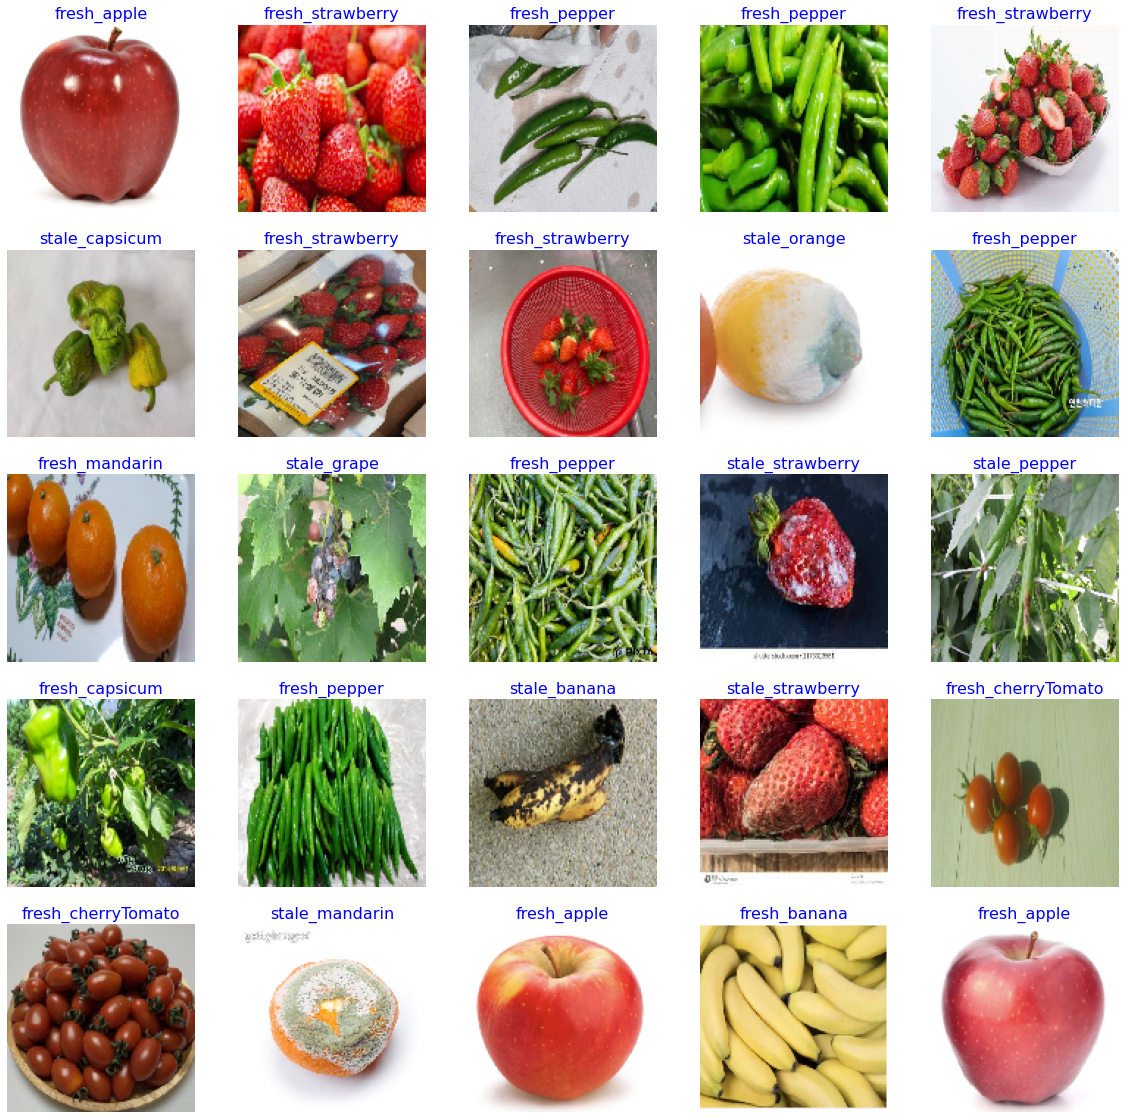

In [ ]:
show_image_samples(train_gen)

### 배경색과 전경색을 RGB로 텍스트에 입혀주는 함수

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    # back_tupple로 지정된 배경과 함께 fore_tupple로 지정된 전경색으로 text_msg를 인쇄 
    # text_msg는 텍스트, fore_tupple은 전경색 튜플 (r,g,b), back_tupple은 배경색 튜플 (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # 기본 인쇄 색상을 다시 검정색으로 되돌림
    return

### 모델 만들기

In [ ]:
model_name='InceptionResNetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

219055592/219055592 [==============================] - 11s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


### 콜백의 하위 클래스를 만들어서 학습률을 제어하고, 각 횟수별 학습 결과를 출력

In [ ]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # 학습률이 조정되기 전에 개선되지 않은 횟수를 지정
        self.stop_patience=stop_patience
        self.threshold=threshold # 학습률이 검증 손실에 따라 조정될 때 훈련 정확도 임계값을 지정
        self.factor=factor # 학습률을 감소시킬 팩터값
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # 초기 학습률을 확인하고 self.lr에 저장
        self.highest_tracc=0.0 # 가장 높은 훈련 정확도를 0으로 설정
        self.lowest_vloss=np.inf # 최소 유효성 검사 손실을 무한대로 설정
        #self.count=0 # 학습 후 향상되지 않은 횟수를 세는 초기값을 0으로 설정
        #self.stop_count=0 # 개선 없이 학습률이 조정된 횟수 초기값을 0으로 설정  
        self.initial_epoch=initial_epoch 
        #self.epochs=epochs
        best_weights=self.model.get_weights() # 훈련이 완료된 후 가중치를 로드할 수 있도록 클래스를 유효하게 설정        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        
    def on_epoch_begin(self,epoch, logs=None): 
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # 각 횟수 실행의 마지막
        later=time.time()
        duration=later-self.now        
        if epoch== self.initial_epoch or LRA.reset==True:  
            LRA.reset=False           
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print_in_color(msg, (244,252,3), (55,65,80)) 
            
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # 현재 학습률을 가져옴
        current_lr=lr
        v_loss=logs.get('val_loss')  # 이번 회차의 검증 손실을 가져옴
        acc=logs.get('accuracy')  # 학습 정확도를 가져옴
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # 학습 정확도가 임계값 미만일 경우 학습 정확도에 따라 학습률을 조정
            monitor='accuracy'
            if acc>self.highest_tracc: # 이번 회차에서 향상된 학습 정확도                
                self.highest_tracc=acc # 새로운 최고 학습 정확도 설정
                LRA.best_weights=self.model.get_weights() # 학습 정확도가 향상된 경우 가중치를 저장함
                self.count=0 # 학습 정확도가 향상되면 횟수를 0으로 돌림
                self.stop_count=0 # 횟수가 0이되면 멈춤
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # 대기 회차에서 일어난다면 학습 정확도를 체크하지 않는다.
                # 이 땐 학습률을 조정함
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # 팩터로 학습률 조정
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # 최적화 도구 내의 학습률 설정
                    self.count=0 # 횟수를 0으로 돌림
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # N공간 내의 더 좋은 지점으로 되돌아감                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # 대기 카운터 증가                    
        else: # 교육 정확도가 임계값 이상이면 검증 손실값에 따라 학습 속도를 조정
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # 검증 손실값이 향상됐는지 확인 
                self.lowest_vloss=v_loss # 가장 낮은 검증 손실값을 대체                
                LRA.best_weights=self.model.get_weights() # 검증 손실값이 향상되었으므로 가중치를 저장
                self.count=0 # 검증 손실이 향상되었으므로 카운터를 초기화  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # 검증 손실값이 향상되지 않음
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # 학습률을 조정
                    self.stop_count=self.stop_count + 1 # 학습률이 조정되었으므로 중지 카운터를 늘림 
                    self.count=0 # 카운터 초기화
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # 최적화 도구 내의 학습률 설정
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # N공간 내의 더 좋은 지점으로 되돌아감
                else: 
                    self.count =self.count +1 # 대기 카운터를 증가시킴                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # 학습 속도가 개선되지 않고 stop_count가 조정되었는지 확인
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # 학습 중지

### 콜백값을 세부 지정하고 모델 학습

In [ ]:
epochs =10
patience= 1 # 모니터링 값이 개선되지 않을 경우 lr을 조정하기 전에 지켜볼 회수
stop_patience =3 # 모니터링 값이 개선되지 않을 경우 학습을 중지하기 전에 지켜볼 회수
threshold=.9 # 학습 정확도가 임계값보다 낮은 경우 모니터 정확도를 조정하고 그렇지 않으면 검증 손실을 지켜봄
factor=.5 # 학습률 감소 팩터
dwell=True # 실험 결과 현재 회수에서 개선되지 않으면 모델 가중치를 이전 회수의 가중치로 다시 설정
freeze=False # True이면 기본 모델 증량을 자유롭게 함

callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs  # 출력할 마지막 회수의 값을 결정
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0, class_weight=class_weight)

 Starting training using base model InceptionResNetV2 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /10     7.077   59.013   4.97124  77.912   0.00100  0.00100  accuracy  2672.45 

 2 /10     4.821   84.767   3.96784  88.755   0.00100  0.00100  accuracy   30.30  

 3 /10     3.954   92.763   3.51160  94.378   0.00100  0.00100  val_loss   29.99  

 4 /10     3.390   96.985   3.27724  92.369   0.00100  0.00100  val_loss   31.67  

 5 /10     3.026   98.258   2.94586  93.976   0.00100  0.00100  val_loss   29.94  

 6 /10     2.689   98.839   2.61447  93.976   0.00100  0.00100  val_loss   30.32  

 7 /10     2.421   98.906   2.43235  91.968   0.00100  0.00100  val_loss   31.56  

 8 /10     2.131   99.464   2.13105  93.574   0.00100  0.00100  val_loss   29.95  

 9 /10     1.880   99.620   1.95025  93.173   0.00100  0.00100  val_loss   29.81  

10 /10     1.712   99.196   1.82807  92.771   0.00100  0.00100  val_loss   29.56  



### 학습 데이터를 보여주는 함수 정의

In [ ]:
def tr_plot(tr_data, start_epoch):
    # 학습 및 검증 데이터 구성
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss) # 검증 손실값이 가장 낮은 회차
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### 오차 행렬과 분류 보고서를 보여주는 함수 정의

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # 딕셔너리 {정수인 클래스 번호: 문자열인 클래스 이름}
    # save_dir에 new_dir를 텍스트로 저장
    classes=list(new_dict.values())     # 문자열인 클래스 이름 리스트
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # 레이블은 정수값
        if pred_index != true_index: # 오분류가 발생했을 경우
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # 클래스 c에 오류가 발생한 횟수를 포함한 목록
                plot_class.append(value)   # 클래스 저장 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # 오차행렬 만들기 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### 모델을 평가하고 저장

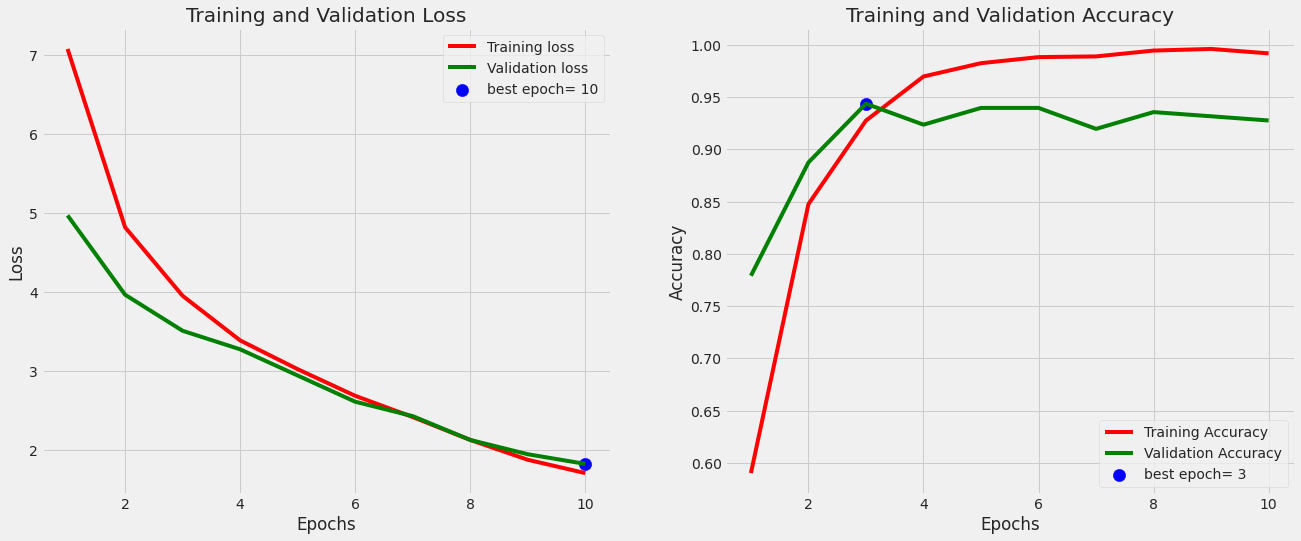

5/5 [==============================] - 119s 29s/step - loss: 1.9089 - accuracy: 0.8996
accuracy on the test set is 89.96 %



In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='fruits'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### 테스트 세트로 예측하고 오차 행렬과 분류에 대한 결과 보고서를 생성

5/5 [==============================] - 4s 273ms/step


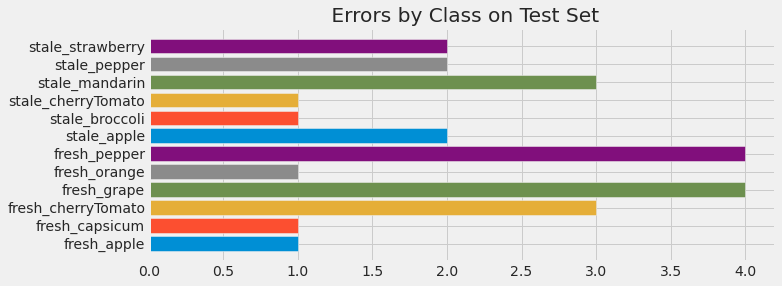

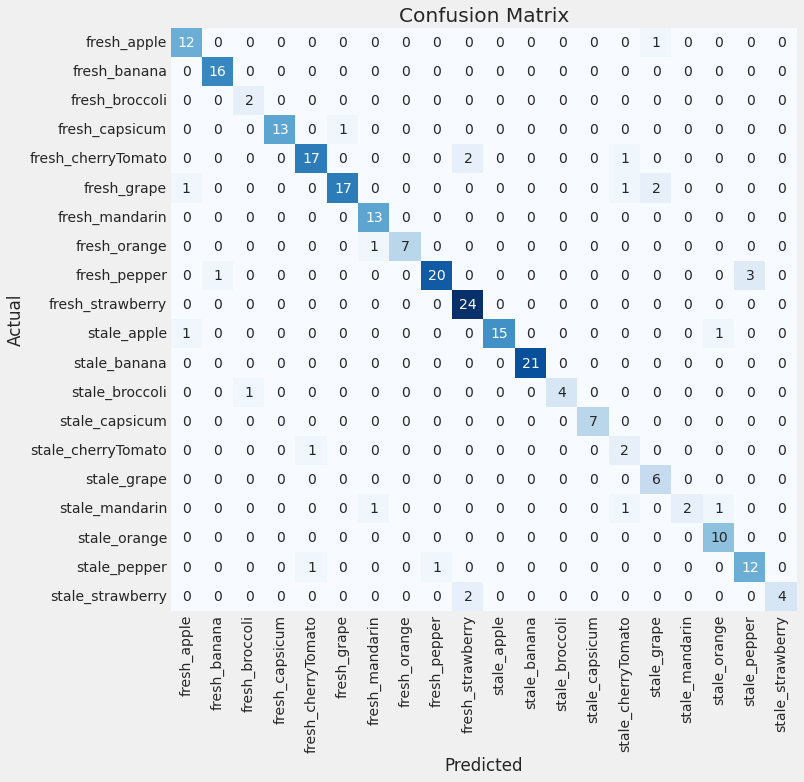

Classification Report:
----------------------
                     precision    recall  f1-score   support

       fresh_apple       0.86      0.92      0.89        13
      fresh_banana       0.94      1.00      0.97        16
    fresh_broccoli       0.67      1.00      0.80         2
    fresh_capsicum       1.00      0.93      0.96        14
fresh_cherryTomato       0.89      0.85      0.87        20
       fresh_grape       0.94      0.81      0.87        21
    fresh_mandarin       0.87      1.00      0.93        13
      fresh_orange       1.00      0.88      0.93         8
      fresh_pepper       0.95      0.83      0.89        24
  fresh_strawberry       0.86      1.00      0.92        24
       stale_apple       1.00      0.88      0.94        17
      stale_banana       1.00      1.00      1.00        21
    stale_broccoli       1.00      0.80      0.89         5
    stale_capsicum       1.00      1.00      1.00         7
stale_cherryTomato       0.40      0.67      0.50   

In [ ]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

In [ ]:
# path='c:/Users/park/Downloads/stale_apple.jpeg'
# from PIL import Image
# import numpy as np
# image = Image.open(path)
# image = image.resize((112,112))
# print(np.array(image).shape)
# x = np.expand_dims(np.array(image),0)
# #print(x.shape)
# np.round(model.predict(x),2)